In [5]:
pip install gseapy


Note: you may need to restart the kernel to use updated packages.


In [7]:
pip install numpy scipy pandas matplotlib seaborn


Note: you may need to restart the kernel to use updated packages.


In [9]:
import pandas as pd
import numpy as np
import os
import gseapy as gp
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from scipy.stats import ttest_ind
import matplotlib.patches as mpatches


In [11]:
deg_df = pd.read_csv("resdf_with_symbols_DFS.csv")  

In [13]:
filtered = deg_df.dropna(subset=["log2FoldChange"])
filtered.to_csv("degs.csv")

In [15]:
filtered.columns

Index(['Gene', 'baseMean', 'log2FoldChange', 'lfcSE', 'stat', 'pvalue', 'padj',
       'neglog10padj'],
      dtype='object')

In [17]:
filtered.index

Index([    0,     1,     2,     3,     4,     6,     7,     8,    10,    11,
       ...
       40786, 40787, 40788, 40789, 40790, 40791, 40792, 40793, 40794, 40795],
      dtype='int64', length=37652)

In [19]:
filtered.set_index("Gene")

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,neglog10padj
Gene,,,,,,,
A1BG,9.775635,0.978171,0.279735,3.496771,0.000471,0.063714,1.195764
NAT2,7.967465,-0.839761,0.587295,-1.429880,0.152752,0.614950,0.211160
ADA,561.382418,0.556976,0.187255,2.974429,0.002935,0.143451,0.843297
CDH2,6438.746795,-0.043731,0.502892,-0.086960,0.930704,0.985620,0.006291
AKT3,875.369756,-0.461615,0.342930,-1.346092,0.178273,0.647125,0.189012
...,...,...,...,...,...,...,...
KCNE2,0.969380,-0.082878,0.518131,-0.159956,0.872916,NaN,NaN
DGCR2,6705.504461,-0.087901,0.146255,-0.601013,0.547831,0.879969,0.055533
CASP8AP2,837.341513,-0.181146,0.160164,-1.131004,0.258053,0.725187,0.139550


In [21]:
filtered = filtered.rename(columns={"pvalue": "pval", "padj": "fdr"})

print(filtered.columns.tolist())

['Gene', 'baseMean', 'log2FoldChange', 'lfcSE', 'stat', 'pval', 'fdr', 'neglog10padj']


In [23]:
filtered = filtered.dropna(subset=["pval", "fdr"])  # Remove rows where pvalue or padj is missing
filtered.to_csv("degs2.csv")

In [25]:
ranked_genes = filtered.set_index("Gene")["log2FoldChange"].sort_values(ascending=False)

# Run GSEA using KEGG pathways
gsea_results = gp.prerank(
    rnk=ranked_genes, 
    gene_sets="KEGG_2021_Human",
    outdir="gsea_results", 
    permutation_num=100,
    seed=42
)

print(gsea_results.res2d[["Term", "NES", "NOM p-val", "FDR q-val"]])


                                          Term       NES NOM p-val FDR q-val
0                         Histidine metabolism  2.171888       0.0       0.0
1                                     Ribosome -1.972305       0.0  0.012705
2                       Synaptic vesicle cycle   1.94207       0.0   0.01132
3                          Tyrosine metabolism  1.918093       0.0  0.007547
4     Glycine, serine and threonine metabolism  1.887418       0.0   0.00566
..                                         ...       ...       ...       ...
301                      p53 signaling pathway -0.512022       1.0       1.0
302  SNARE interactions in vesicular transport  0.509335       1.0       1.0
303                 Nucleotide excision repair  0.412211       1.0  0.999896
304                     Fatty acid degradation -0.408535       1.0       1.0
305                   Homologous recombination -0.393121       1.0       1.0

[306 rows x 4 columns]


In [27]:
print(gsea_results.res2d.columns.tolist())

['Name', 'Term', 'ES', 'NES', 'NOM p-val', 'FDR q-val', 'FWER p-val', 'Tag %', 'Gene %', 'Lead_genes']


In [28]:
logfc_threshold = 1
pval_threshold = 0.05

if "log2FoldChange" not in filtered.columns or "pval" not in filtered.columns:
    raise ValueError("Columns 'log2FoldChange' or 'pval' not found in DataFrame.")

upregulated = filtered[(filtered["log2FoldChange"] > logfc_threshold) & (filtered["pval"] < pval_threshold)]
downregulated = filtered[(filtered["log2FoldChange"] < -logfc_threshold) & (filtered["pval"] < pval_threshold)]

print("\nUpregulated DEGs:")
print(upregulated.head())  # Show first few rows

print("\nDownregulated DEGs:")
print(downregulated.head())  



Upregulated DEGs:
           Gene    baseMean  log2FoldChange     lfcSE      stat      pval  \
6     LINC02584    3.679709        1.314636  0.540992  2.430045  0.015097   
958     TMEM221  443.471655        1.130307  0.459931  2.457557  0.013989   
982       PRR32   14.591541        1.896958  0.729307  2.601042  0.009294   
1017     MTA3P1    1.054096        1.745222  0.551932  3.162021  0.001567   
1039    ZNRF2P3    2.122334        1.082230  0.532419  2.032666  0.042086   

           fdr  neglog10padj  
6     0.277460      0.556799  
958   0.269851      0.568876  
982   0.223269      0.651171  
1017  0.109217      0.961709  
1039  0.404730      0.392835  

Downregulated DEGs:
             Gene   baseMean  log2FoldChange     lfcSE      stat      pval  \
165    LIN28B-AS1   3.132936       -1.858127  0.795877 -2.334693  0.019559   
217        MIR938   1.783907       -1.176700  0.531987 -2.211895  0.026974   
250          EGOT  29.460671       -1.018506  0.350834 -2.903098  0.003695   

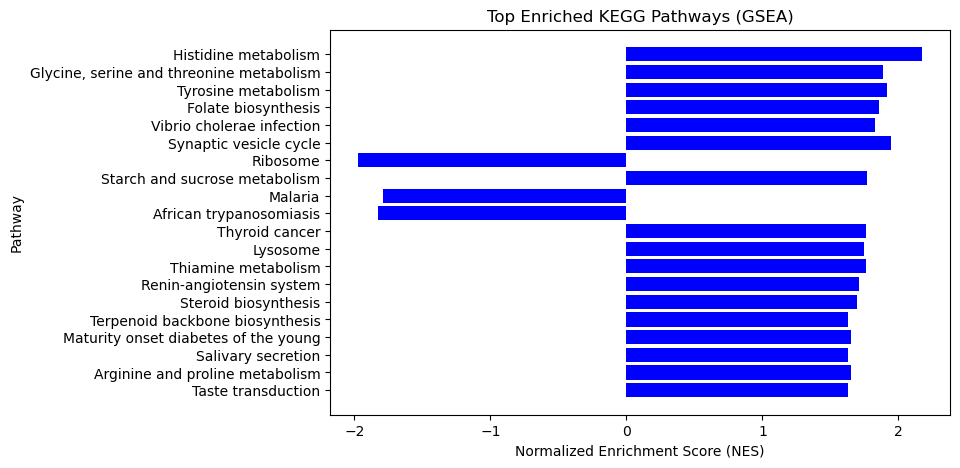

In [29]:
import matplotlib.pyplot as plt

# Select top 10 enriched pathways
top_pathways = gsea_results.res2d.sort_values("FDR q-val").head(20)

plt.figure(figsize=(8, 5))
plt.barh(top_pathways["Term"], top_pathways["NES"], color="blue")
plt.xlabel("Normalized Enrichment Score (NES)")
plt.ylabel("Pathway")
plt.title("Top Enriched KEGG Pathways (GSEA)")
plt.gca().invert_yaxis()

plt.savefig("GSEA_top_pathways_KEGG.png", dpi=300, bbox_inches='tight')
plt.show()


# Hallmark Analysis

In [35]:
import requests

url = "https://data.broadinstitute.org/gsea-msigdb/msigdb/release/2023.1.Hs/h.all.v2023.1.Hs.symbols.gmt"

gmt_file = "h.all.v2023.1.Hs.symbols.gmt"
response = requests.get(url)
with open(gmt_file, "wb") as f:
    f.write(response.content)

print("Hallmark gene set downloaded successfully!")

Hallmark gene set downloaded successfully!


In [37]:
libs = gp.get_library_name(organism='Human')
print(libs)  

['ARCHS4_Cell-lines', 'ARCHS4_IDG_Coexp', 'ARCHS4_Kinases_Coexp', 'ARCHS4_TFs_Coexp', 'ARCHS4_Tissues', 'Achilles_fitness_decrease', 'Achilles_fitness_increase', 'Aging_Perturbations_from_GEO_down', 'Aging_Perturbations_from_GEO_up', 'Allen_Brain_Atlas_10x_scRNA_2021', 'Allen_Brain_Atlas_down', 'Allen_Brain_Atlas_up', 'Azimuth_2023', 'Azimuth_Cell_Types_2021', 'BioCarta_2013', 'BioCarta_2015', 'BioCarta_2016', 'BioPlanet_2019', 'BioPlex_2017', 'CCLE_Proteomics_2020', 'CORUM', 'COVID-19_Related_Gene_Sets', 'COVID-19_Related_Gene_Sets_2021', 'Cancer_Cell_Line_Encyclopedia', 'CellMarker_2024', 'CellMarker_Augmented_2021', 'ChEA_2013', 'ChEA_2015', 'ChEA_2016', 'ChEA_2022', 'Chromosome_Location', 'Chromosome_Location_hg19', 'ClinVar_2019', 'DGIdb_Drug_Targets_2024', 'DSigDB', 'Data_Acquisition_Method_Most_Popular_Genes', 'DepMap_CRISPR_GeneDependency_CellLines_2023', 'DepMap_WG_CRISPR_Screens_Broad_CellLines_2019', 'DepMap_WG_CRISPR_Screens_Sanger_CellLines_2019', 'Descartes_Cell_Types_and

In [39]:
# Run GSEA using Hallmark
gsea_results_hallmark = gp.prerank(
    rnk=ranked_genes, 
    gene_sets="h.all.v2023.1.Hs.symbols.gmt",
    outdir="gsea_hallmark_results",  # Save results
    permutation_num=100,
    seed=42
)

print(gsea_results_hallmark.res2d[["Term", "NES", "NOM p-val", "FDR q-val"]])

print(gsea_results_hallmark.res2d.columns.tolist())

                                          Term       NES NOM p-val FDR q-val
0           HALLMARK_INTERFERON_ALPHA_RESPONSE  1.776068       0.0       0.0
1              HALLMARK_ESTROGEN_RESPONSE_LATE  1.679616       0.0  0.027523
2                    HALLMARK_MTORC1_SIGNALING  1.560633       0.0  0.091743
3             HALLMARK_TNFA_SIGNALING_VIA_NFKB -1.527519       0.0  0.067541
4             HALLMARK_ESTROGEN_RESPONSE_EARLY  1.447083       0.0  0.172018
5                        HALLMARK_ADIPOGENESIS  1.438499       0.0  0.143119
6                   HALLMARK_ANDROGEN_RESPONSE  1.406638  0.037037  0.142202
7               HALLMARK_FATTY_ACID_METABOLISM  1.343744      0.05   0.21232
8                   HALLMARK_KRAS_SIGNALING_DN  1.293431       0.0  0.264908
9                     HALLMARK_SPERMATOGENESIS  1.293221  0.027778  0.235474
10                         HALLMARK_PEROXISOME  1.288206  0.060606  0.220183
11    HALLMARK_REACTIVE_OXYGEN_SPECIES_PATHWAY  1.264438  0.153846  0.265221

In [40]:
logfc_threshold = 1
pval_threshold = 0.05

if "log2FoldChange" not in filtered.columns or "pval" not in filtered.columns:
    raise ValueError("Columns 'log2FoldChange' or 'pval' not found in DataFrame.")

upregulated = filtered[(filtered["log2FoldChange"] > logfc_threshold) & (filtered["pval"] < pval_threshold)]
downregulated = filtered[(filtered["log2FoldChange"] < -logfc_threshold) & (filtered["pval"] < pval_threshold)]

print("\nUpregulated DEGs:")
print(upregulated.head())  

print("\nDownregulated DEGs:")
print(downregulated.head()) 


Upregulated DEGs:
           Gene    baseMean  log2FoldChange     lfcSE      stat      pval  \
6     LINC02584    3.679709        1.314636  0.540992  2.430045  0.015097   
958     TMEM221  443.471655        1.130307  0.459931  2.457557  0.013989   
982       PRR32   14.591541        1.896958  0.729307  2.601042  0.009294   
1017     MTA3P1    1.054096        1.745222  0.551932  3.162021  0.001567   
1039    ZNRF2P3    2.122334        1.082230  0.532419  2.032666  0.042086   

           fdr  neglog10padj  
6     0.277460      0.556799  
958   0.269851      0.568876  
982   0.223269      0.651171  
1017  0.109217      0.961709  
1039  0.404730      0.392835  

Downregulated DEGs:
             Gene   baseMean  log2FoldChange     lfcSE      stat      pval  \
165    LIN28B-AS1   3.132936       -1.858127  0.795877 -2.334693  0.019559   
217        MIR938   1.783907       -1.176700  0.531987 -2.211895  0.026974   
250          EGOT  29.460671       -1.018506  0.350834 -2.903098  0.003695   

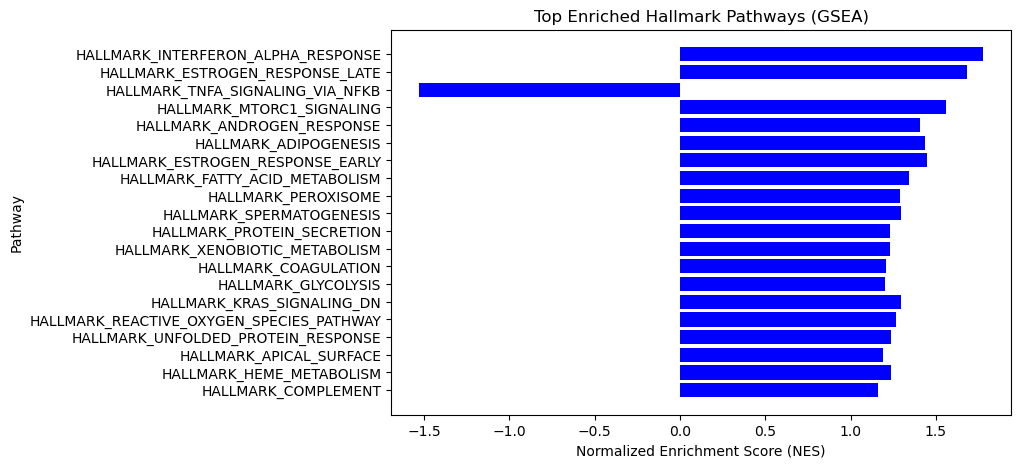

In [41]:
import matplotlib.pyplot as plt

# Select top 10 enriched pathways
top_pathways = gsea_results_hallmark.res2d.sort_values("FDR q-val").head(20)

plt.figure(figsize=(8, 5))
plt.barh(top_pathways["Term"], top_pathways["NES"], color="blue")
plt.xlabel("Normalized Enrichment Score (NES)")
plt.ylabel("Pathway")
plt.title("Top Enriched Hallmark Pathways (GSEA)")
plt.gca().invert_yaxis()
plt.savefig("GSEA_top_pathways_Hallmark.png", dpi=300, bbox_inches='tight')

plt.show()


# GO

In [46]:
# URLs for GO gene sets
go_bp_url = "https://data.broadinstitute.org/gsea-msigdb/msigdb/release/2023.1.Hs/c5.go.bp.v2023.1.Hs.symbols.gmt"
go_cc_url = "https://data.broadinstitute.org/gsea-msigdb/msigdb/release/2023.1.Hs/c5.go.cc.v2023.1.Hs.symbols.gmt"
go_mf_url = "https://data.broadinstitute.org/gsea-msigdb/msigdb/release/2023.1.Hs/c5.go.mf.v2023.1.Hs.symbols.gmt"

for url, name in zip([go_bp_url, go_cc_url, go_mf_url], 
                     ["c5.go.bp.gmt", "c5.go.cc.gmt", "c5.go.mf.gmt"]):
    response = requests.get(url)
    with open(name, "wb") as f:
        f.write(response.content)
    print(f"Downloaded: {name}")

Downloaded: c5.go.bp.gmt
Downloaded: c5.go.cc.gmt
Downloaded: c5.go.mf.gmt


In [47]:
gsea_results_go = gp.prerank(
    rnk="ranked_genes.rnk",
    gene_sets="c5.go.mf.gmt",  
    outdir="gsea_go_mf_results",
    permutation_num=100,
    seed=42
)

2025-03-14 17:28:25,793 [WARNING] Duplicated values found in preranked stats: 27.06% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


In [49]:
significant_pathways = gsea_results_go.res2d[gsea_results_go.res2d["FDR q-val"] < 0.05]["Term"].tolist()

enrichment_dict = gsea_results_go.results
for pathway in significant_pathways:
    print(f"\n{pathway}:")
    print(enrichment_dict[pathway]["lead_genes"]) 


GOMF_ANTIGEN_BINDING:
IGHV2-5;IGLV1-40;IGLV3-1;IGLV6-57;IGLV3-19;IGHV4-34;IGLV7-43;IGKV2D-28;IGKV1-39;IGLV1-51;IGHV3-11;IGHV3-23;IGHV2-70;IGKV2-30;IGLV3-25;IGKV1-16;IGHV4-39;IGHD;IGLV2-23;IGHA1;IGKV3-20;TRGV3;IGKV1D-33;IGLV1-44;IGHV3-48;PLG;CD209;TRBV12-3;LILRA2;IGHV3-53;TRAV19;TRAV12-2;IGHV4-59;IGHE;JCHAIN;TRAV12-1;KLRD1;IGLV3-21;IGKV1-5;TRAV23DV6;TRBV28;TRAV29DV5;ITGA4;LILRA1;HLA-H;LAG3;IGKV3-15;IGLV2-11;HLA-F;TRAV12-3;TRAV8-4;SLAMF1;IGLV2-8;IGKC;IGHA2;TRBV7-9

GOMF_EXTRACELLULAR_MATRIX_STRUCTURAL_CONSTITUENT_CONFERRING_TENSILE_STRENGTH:
COL4A3;COL11A2;COL9A3;COL4A4;COL10A1;COL11A1;COL25A1;COL19A1;COL8A2;COL13A1;COL8A1;COL27A1;COL4A6;COL9A1;COL28A1;COL17A1;COL21A1;COL14A1


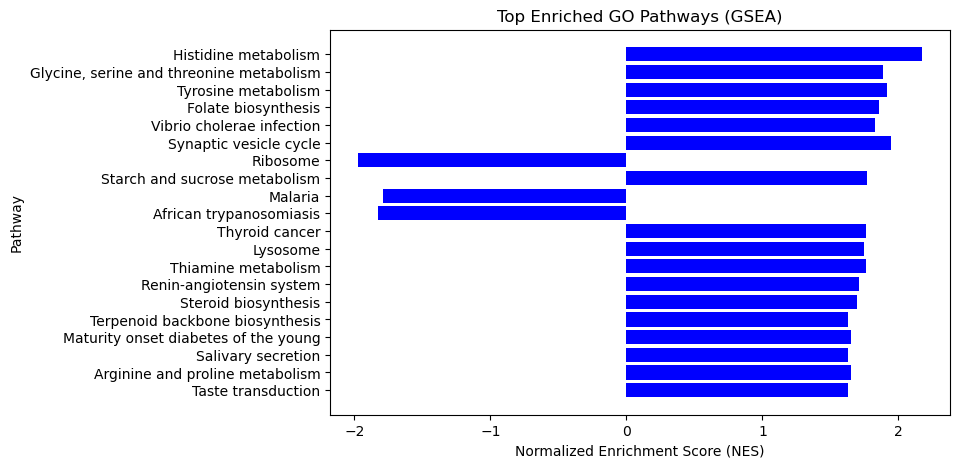

In [51]:
# Select top 10 enriched pathways
top_pathways = gsea_results.res2d.sort_values("FDR q-val").head(20)

# Plot
plt.figure(figsize=(8, 5))
plt.barh(top_pathways["Term"], top_pathways["NES"], color="blue")
plt.xlabel("Normalized Enrichment Score (NES)")
plt.ylabel("Pathway")
plt.title("Top Enriched GO Pathways (GSEA)")
plt.gca().invert_yaxis()
plt.savefig("GSEA_top_pathways_GO.png", dpi=300, bbox_inches='tight')

plt.show()

# ECM Remodelling Pathways Exploration

In [56]:
# Define keywords to filter ECM and CAF pathways
ecm_keywords = ["extracellular matrix", "collagen", "metalloproteinase", "focal adhesion"]
caf_keywords = ["fibroblast", "TGF", "cytokine", "stromal", "angiogenesis", "hypoxia"]

ecm_related = gsea_results_go.res2d[gsea_results_go.res2d["Term"].str.contains("|".join(ecm_keywords), case=False)]
caf_related = gsea_results_go.res2d[gsea_results_go.res2d["Term"].str.contains("|".join(caf_keywords), case=False)]

# Display ECM-related pathways
print("ECM Remodeling GO Terms:")
print(ecm_related)

# Display CAF-related pathways
print("CAF-Tumor Interaction GO Terms:")
print(caf_related)

ecm_related.to_csv("ECM_Remodeling_GO_Terms.csv", index=False)
caf_related.to_csv("CAF_Tumor_Interaction_GO_Terms.csv", index=False)
print("Filtered GO results saved as CSV.")

ECM Remodeling GO Terms:
        Name                   Term       ES       NES NOM p-val FDR q-val  \
248  prerank  GOMF_COLLAGEN_BINDING -0.40243 -1.148593  0.287879       1.0   

    FWER p-val  Tag %  Gene %  \
248        1.0  24/66  24.91%   

                                            Lead_genes  
248  DSPP;MMP12;PAK1;ADGRG6;ANTXR1;DDR2;ITGA10;ITGA...  
CAF-Tumor Interaction GO Terms:
        Name                                            Term        ES  \
48   prerank  GOMF_FIBROBLAST_GROWTH_FACTOR_RECEPTOR_BINDING  0.597875   
51   prerank                 GOMF_CYTOKINE_RECEPTOR_ACTIVITY -0.490493   
181  prerank           GOMF_FIBROBLAST_GROWTH_FACTOR_BINDING  0.483739   
220  prerank                  GOMF_CYTOKINE_RECEPTOR_BINDING -0.330976   
269  prerank                          GOMF_CYTOKINE_ACTIVITY -0.312223   
359  prerank                           GOMF_CYTOKINE_BINDING -0.322562   

          NES NOM p-val FDR q-val FWER p-val   Tag %  Gene %  \
48   1.483503  0.05405

/var/folders/mt/p356y_1s3r9bvym2q2h_vzxh0000gn/T/ipykernel_91117/3628388458.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=df["Term"], x=df["NES"], palette="coolwarm", orient="h")


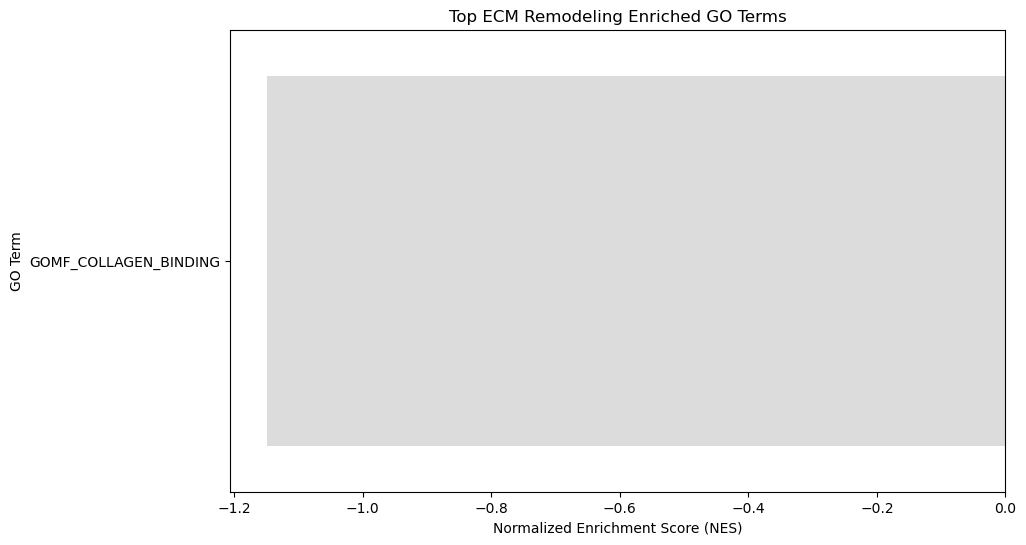

/var/folders/mt/p356y_1s3r9bvym2q2h_vzxh0000gn/T/ipykernel_91117/3628388458.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=df["Term"], x=df["NES"], palette="coolwarm", orient="h")


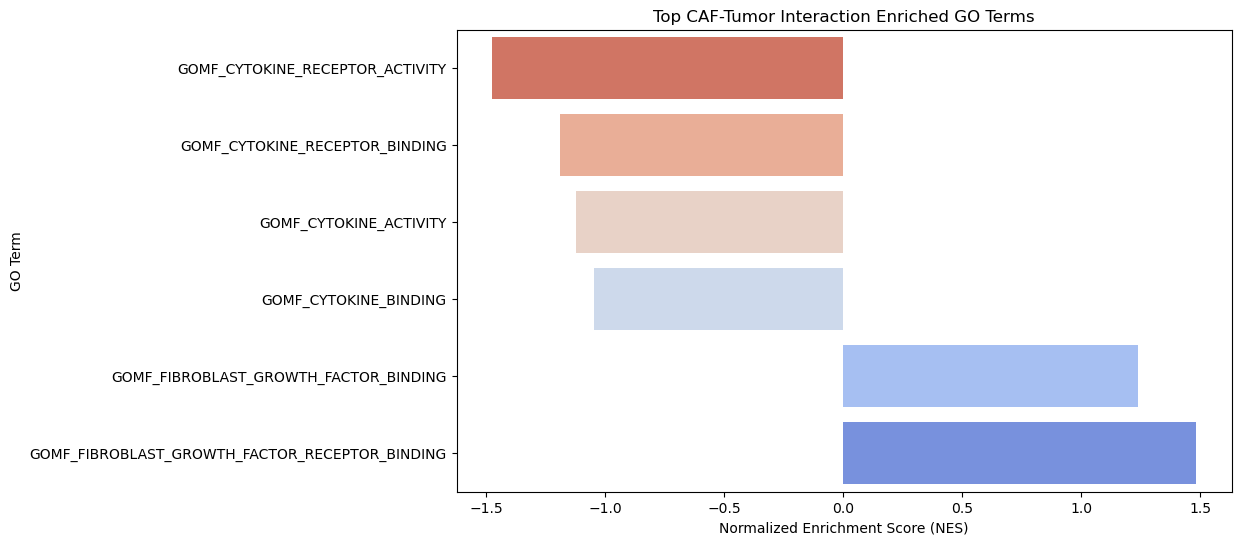

In [57]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_enrichment(df, title):
    df = df.sort_values(by="NES", ascending=False).head(20)

    plt.figure(figsize=(10, 6))
    sns.barplot(y=df["Term"], x=df["NES"], palette="coolwarm", orient="h")
    plt.xlabel("Normalized Enrichment Score (NES)")
    plt.ylabel("GO Term")
    plt.title(title)
    plt.gca().invert_yaxis()  
    plt.show()

plot_enrichment(ecm_related, "Top ECM Remodeling Enriched GO Terms")

plot_enrichment(caf_related, "Top CAF-Tumor Interaction Enriched GO Terms")

/var/folders/mt/p356y_1s3r9bvym2q2h_vzxh0000gn/T/ipykernel_91117/3247786114.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=df2["Term"], x=df2["NES"], palette=colors, orient="h")


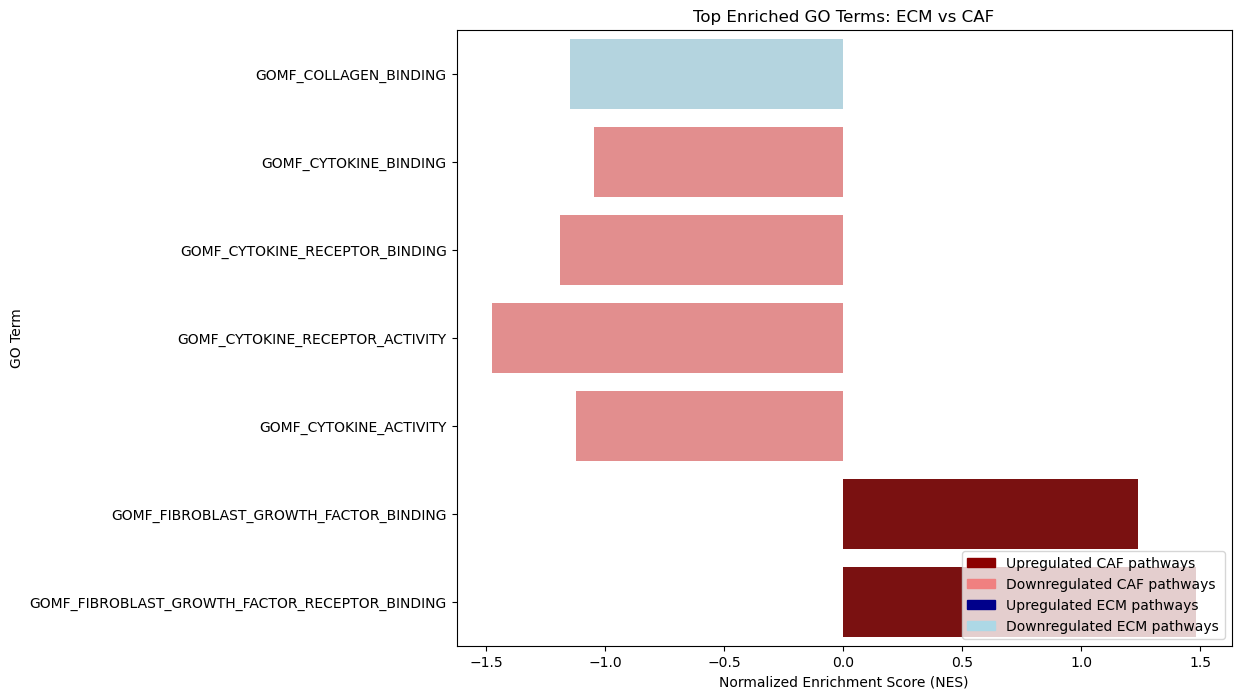

In [58]:
def plot_combined_enrichment(df1, df2, title, save_path=None):
    df1 = df1.sort_values(by="NES", ascending=False).head(20)
    df2 = df2.sort_values(by="NES", ascending=False).head(20)

    combined_terms = list(set(df1["Term"]).union(set(df2["Term"])))  # Unique terms
    df1 = df1.set_index("Term").reindex(combined_terms).reset_index()
    df2 = df2.set_index("Term").reindex(combined_terms).reset_index()

    plt.figure(figsize=(10, 8))

    sns.barplot(y=df1["Term"], x=df1["NES"], color="lightblue", orient="h")

    colors = ["lightcoral" if nes < 0 else "darkred" for nes in df2["NES"]]

    sns.barplot(y=df2["Term"], x=df2["NES"], palette=colors, orient="h")

    legend_patches = [
        mpatches.Patch(color="darkred", label="Upregulated CAF pathways"),
        mpatches.Patch(color="lightcoral", label="Downregulated CAF pathways"),
        mpatches.Patch(color="darkblue", label="Upregulated ECM pathways"),
        mpatches.Patch(color="lightblue", label="Downregulated ECM pathways"),
    ]

    plt.xlabel("Normalized Enrichment Score (NES)")
    plt.ylabel("GO Term")
    plt.title(title)
    plt.legend(handles=legend_patches, loc="lower right")  # Use custom legend
    plt.gca().invert_yaxis()  # Invert y-axis for readability
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

plot_combined_enrichment(ecm_related, caf_related, "Top Enriched GO Terms: ECM vs CAF", save_path="GO_enrichment_ECM_CAF.png")

# Extract key genes from ECM and CAF pathways

In [60]:
significant_ecm = ecm_related[ecm_related["FDR q-val"] < 0.5]
significant_caf = caf_related[caf_related["FDR q-val"] < 0.5]

ecm_genes = set()
caf_genes = set()

for pathway in significant_ecm["Term"]:
    ecm_genes.update(gsea_results_go.results[pathway]["lead_genes"])

for pathway in significant_caf["Term"]:
    caf_genes.update(gsea_results_go.results[pathway]["lead_genes"])

selected_genes = list(ecm_genes.union(caf_genes))
print(f"Total ECM + CAF genes: {len(selected_genes)}")

Total ECM + CAF genes: 0


# ok that didn't work. i will try GOATOOLS and customize now

In [62]:
!pip install goatools

In [117]:
from goatools.obo_parser import GODag
from goatools.goea.go_enrichment_ns import GOEnrichmentStudy
import requests

In [119]:
obo_url = "http://current.geneontology.org/ontology/go-basic.obo"
obo_file = "go-basic.obo"

print("Downloading GO ontology file...")

response = requests.get(obo_url)

In [121]:
obo_file = "go-basic.obo"
godag = GODag(obo_file)

print("GO ontology successfully loaded")

go-basic.obo: fmt(1.2) rel(2025-02-06) 43,597 Terms
GO ontology successfully loaded


In [123]:
count = pd.read_csv("count_data_DFS.csv", index_col=0)
print(count.shape)  

Count data loaded successfully!
(371, 40796)


In [125]:
study_genes = set(selected_genes)  
background_genes = set(count.index)  
print(f"Total genes for enrichment: {len(study_genes)}")
print(f"Total background genes: {len(background_genes)}")

Total genes for enrichment: 0
Total background genes: 371


In [127]:
go_annotation_url = "http://current.geneontology.org/annotations/goa_human.gaf.gz"
go_annotation_file = "goa_human.gaf.gz"

print("Downloading gene-to-GO annotation file...")
response = requests.get(go_annotation_url)
if response.status_code == 200:
    with open(go_annotation_file, "wb") as f:
        f.write(response.content)

In [129]:
import gzip
import shutil

compressed_file = "goa_human.gaf.gz"
decompressed_file = "goa_human.gaf"

with gzip.open(compressed_file, "rb") as f_in:
    with open(decompressed_file, "wb") as f_out:
        shutil.copyfileobj(f_in, f_out)

In [131]:
gene2go = read_gaf(decompressed_file)

HMS:0:00:10.116949 784,711 annotations READ: goa_human.gaf 
36385 IDs in loaded association branch, BP


In [133]:
go_enrich = GOEnrichmentStudy(
    background_genes, 
    gene2go,         
    godag,          
    propagate_counts=True,
    alpha=0.05,       
    methods=['fdr_bh'] 
)

results = go_enrich.run_study(study_genes)

results_df = pd.DataFrame([
    {
        "GO Term": r.GO,
        "Name": r.name,
        "p-value": r.p_fdr_bh,  
        "Enrichment": r.enrichment,
        "Study Count": r.study_count, 
        "Total Count": r.pop_count 
    }
    for r in results if r.p_fdr_bh < 0.05 
])

print("GO Enrichment Results (ECM & CAF):")
print(results_df.head(10)) 

results_df.to_csv("GO_Enrichment_ECM_CAF.csv", index=False)
print("Results saved as 'GO_Enrichment_ECM_CAF.csv'.")


Load  Ontology Enrichment Analysis ...
Propagating term counts up: is_a
  0%      0 of    371 population items found in association

Runing  Ontology Analysis: current study set of 0 IDs.
GO Enrichment Results (ECM & CAF):
Empty DataFrame
Columns: []
Index: []
Results saved as 'GO_Enrichment_ECM_CAF.csv'.


In [135]:
print(len(gene2go)) 

36385


In [137]:
mapped_genes = [g for g in study_genes if g in gene2go]
print(f"Genes in study set: {len(study_genes)}")
print(f"Genes mapped to GO terms: {len(mapped_genes)}")

Genes in study set: 0
Genes mapped to GO terms: 0


In [139]:
print("Example study genes:", list(study_genes)[:10])  

Example study genes: []


In [145]:
print("Total ECM genes:", len(ecm_genes))
print("Total CAF genes:", len(caf_genes))

Total ECM genes: 0
Total CAF genes: 0


In [147]:
significant_ecm = ecm_related[ecm_related["FDR q-val"] < 0.2]
significant_caf = caf_related[caf_related["FDR q-val"] < 0.2]

In [149]:
# Check ECM/CAF genes
print("Total ECM genes:", len(significant_ecm))
print("Total CAF genes:", len(significant_caf))

Total ECM genes: 0
Total CAF genes: 0


In [151]:
print("Total pathways in GSEA results:", len(gsea_results_go.res2d))
print(gsea_results_go.res2d.head(10))

Total pathways in GSEA results: 813
      Name                                               Term        ES  \
0  prerank                               GOMF_ANTIGEN_BINDING -0.626733   
1  prerank            GOMF_STRUCTURAL_CONSTITUENT_OF_RIBOSOME  0.536035   
2  prerank                                 GOMF_E_BOX_BINDING  0.631078   
3  prerank              GOMF_METALLOCARBOXYPEPTIDASE_ACTIVITY  0.658452   
4  prerank                  GOMF_METALLOEXOPEPTIDASE_ACTIVITY  0.593683   
5  prerank                          GOMF_DIPEPTIDASE_ACTIVITY  0.784415   
6  prerank                     GOMF_CARBOXYPEPTIDASE_ACTIVITY  0.599362   
7  prerank                GOMF_PRE_MRNA_5_SPLICE_SITE_BINDING   -0.7411   
8  prerank  GOMF_EXTRACELLULAR_MATRIX_STRUCTURAL_CONSTITUE... -0.674799   
9  prerank            GOMF_CALCIUM_CHANNEL_INHIBITOR_ACTIVITY  0.736619   

        NES NOM p-val FDR q-val FWER p-val   Tag %  Gene %  \
0 -2.033923       0.0  0.008103       0.01  56/119   9.20%   
1  1.940226   

In [153]:
!pip install --upgrade gseapy

/var/folders/mt/p356y_1s3r9bvym2q2h_vzxh0000gn/T/ipykernel_91117/2364887405.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=top_terms["Term"], x=top_terms["NES"], palette="coolwarm", orient="h")


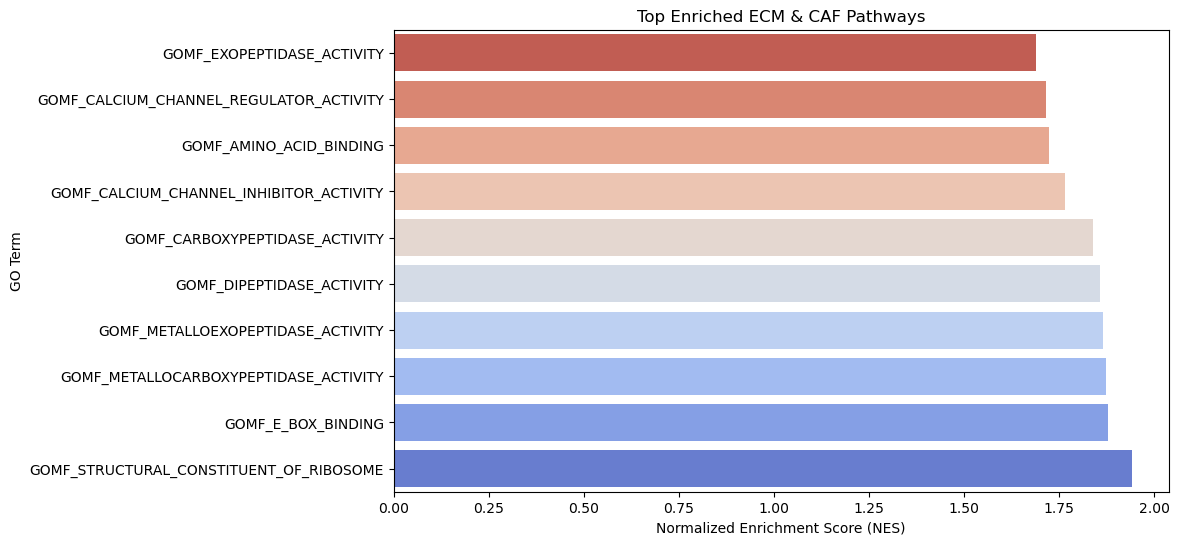

In [68]:
top_terms = gsea_results_go.res2d.sort_values(by="NES", ascending=False).head(10)

plt.figure(figsize=(10, 6))
sns.barplot(y=top_terms["Term"], x=top_terms["NES"], palette="coolwarm", orient="h")
plt.xlabel("Normalized Enrichment Score (NES)")
plt.ylabel("GO Term")
plt.title("Top Enriched ECM & CAF Pathways")
plt.gca().invert_yaxis()  
plt.show()

/var/folders/mt/p356y_1s3r9bvym2q2h_vzxh0000gn/T/ipykernel_91117/1603953194.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=top_terms["Term"], x=top_terms["NES"], palette=colors, orient="h")


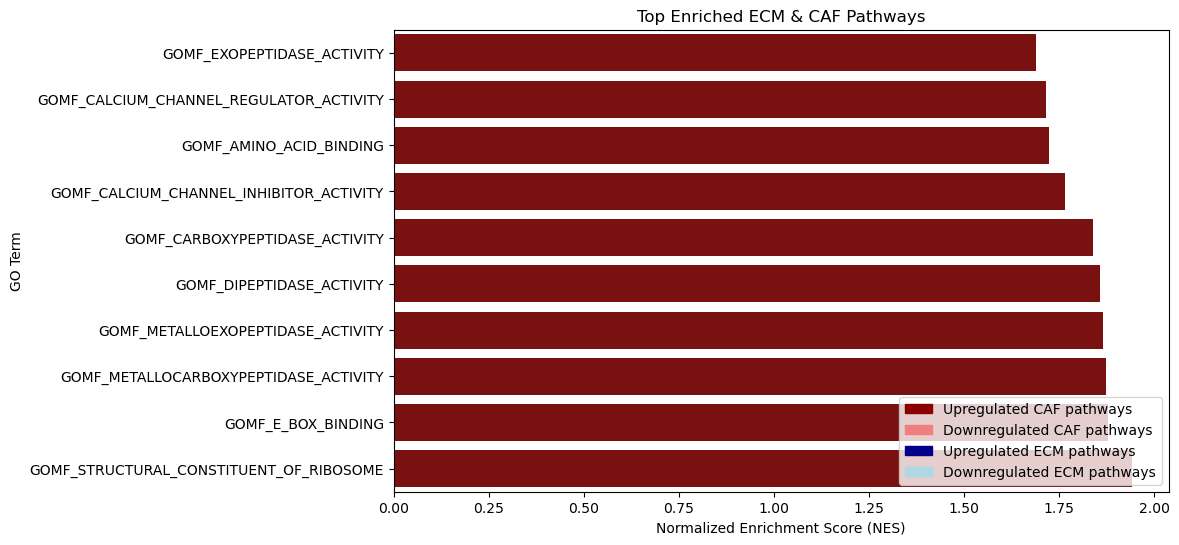

In [63]:
top_terms = gsea_results_go.res2d.sort_values(by="NES", ascending=False).head(10)

colors = []
for nes, term in zip(top_terms["NES"], top_terms["Term"]):
    if nes > 0 and "ECM" in term: 
        colors.append("darkblue")
    elif nes > 0: 
        colors.append("darkred")
    elif nes < 0 and "ECM" in term: 
        colors.append("lightblue")
    else:  
        colors.append("lightcoral")

plt.figure(figsize=(10, 6))
sns.barplot(y=top_terms["Term"], x=top_terms["NES"], palette=colors, orient="h")

legend_patches = [
    mpatches.Patch(color="darkred", label="Upregulated CAF pathways"),
    mpatches.Patch(color="lightcoral", label="Downregulated CAF pathways"),
    mpatches.Patch(color="darkblue", label="Upregulated ECM pathways"),
    mpatches.Patch(color="lightblue", label="Downregulated ECM pathways"),
]

plt.xlabel("Normalized Enrichment Score (NES)")
plt.ylabel("GO Term")
plt.title("Top Enriched ECM & CAF Pathways")
plt.legend(handles=legend_patches, loc="lower right")
plt.gca().invert_yaxis()  
plt.show()